In [1]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm

def convert_to_coco(dataset_dirs, output_file):
    # COCO structure
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Define categories (add your actual category names here)
    categories = ["leaf"]
    coco_categories = [{"id": idx + 1, "name": name, "supercategory": "none"} for idx, name in enumerate(categories)]
    coco_format["categories"].extend(coco_categories)

    annotation_id = 1
    image_id = 1  # Global image ID to keep track across all directories
    
    if type(dataset_dirs) is not list:
        dataset_dirs = [dataset_dirs]

    for dataset_dir in dataset_dirs:
        # Directories for images and labels
        images_dir = os.path.join(dataset_dir, "images")
        labels_dir = os.path.join(dataset_dir, "labels")
        
        image_files = os.listdir(images_dir)
        
        # Process each image and corresponding label
        for image_file in tqdm(image_files, desc=f"Processing {dataset_dir}", total=len(image_files)):
            if not (image_file.endswith(".jpg") or image_file.endswith(".png")):
                continue

            # Image details
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            height, width = image.shape[:2]

            # Add image info to COCO JSON
            coco_format["images"].append({
                "id": image_id,
                "file_name": image_file,
                "height": height,
                "width": width
            })

            # Label file path
            label_file = os.path.join(labels_dir, f"{os.path.splitext(image_file)[0]}.txt")
            if os.path.exists(label_file):
                with open(label_file, "r") as f:
                    for line in f:
                        data = line.strip().split()
                        category_id = int(data[0]) + 1  # Assuming 0-indexed labels, adjust if needed

                        # Bounding box (convert relative to absolute coordinates)
                        x_min, y_min, width_rel, height_rel = map(float, data[1:5])
                        x_min = x_min * width
                        y_min = y_min * height
                        bbox_width = width_rel * width
                        bbox_height = height_rel * height
                        
                        # Segmentation points (also convert relative to absolute coordinates)
                        polygon_points_rel = list(map(float, data[5:]))
                        polygon_points_abs = [
                            [polygon_points_rel[i] * width, polygon_points_rel[i + 1] * height]
                            for i in range(0, len(polygon_points_rel), 2)
                        ]
                        segmentation = [np.array(polygon_points_abs).flatten().tolist()]

                        # Area of the bounding box (for COCO format)
                        area = bbox_width * bbox_height

                        # Add annotation for this object
                        coco_format["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": category_id,
                            "bbox": [x_min, y_min, bbox_width, bbox_height],
                            "area": area,
                            "segmentation": segmentation,
                            "iscrowd": 0
                        })
                        annotation_id += 1

            image_id += 1  # Increment global image ID

    # Write to output file
    with open(output_file, "w") as json_file:
        json.dump(coco_format, json_file, indent=4)

In [40]:
# Convert train set (example usage)
convert_to_coco("_data/synthetic_leaf_instances/train", "_data/coco_synthetic_train.json")

100%|██████████| 8001/8001 [04:21<00:00, 30.60it/s]


In [41]:
convert_to_coco("_data/synthetic_leaf_instances/val", "_data/coco_synthetic_val.json")

100%|██████████| 1999/1999 [01:04<00:00, 30.99it/s]


In [3]:
convert_to_coco(["_data/synthetic_leaf_instances/val", "_data/synthetic_leaf_instances/train"], "_data/coco_synthetic_total.json")

Processing _data/synthetic_leaf_instances/train: 100%|██████████| 8001/8001 [01:48<00:00, 73.50it/s]


In [42]:
import os
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [43]:
coco = COCO('_data/coco_synthetic_train.json')

loading annotations into memory...
Done (t=9.62s)
creating index...
index created!


In [44]:
IMG_ID = 1554

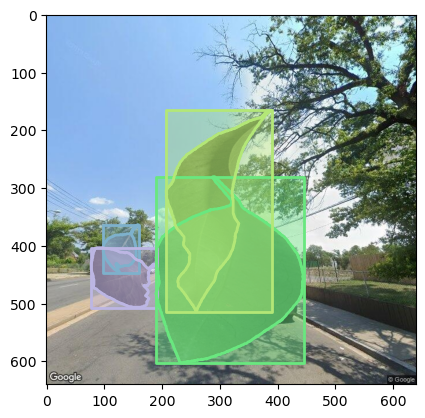

In [45]:
img_info = coco.loadImgs([IMG_ID])[0]
img_file_name = img_info["file_name"]
img = cv2.imread(os.path.join("_data/synthetic_leaf_instances/train/images", img_file_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=[IMG_ID], iscrowd=None)
anns = coco.loadAnns(ann_ids)

plt.imshow(img)
coco.showAnns(anns, draw_bbox=True)
plt.show()

In [ ]:
coco = COCO('_data/coco_synthetic_val.json')

In [ ]:
img_info = coco.loadImgs([IMG_ID])[0]
img_file_name = img_info["file_name"]
img = cv2.imread(os.path.join("_data/synthetic_leaf_instances/val/images", img_file_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=[IMG_ID], iscrowd=None)
anns = coco.loadAnns(ann_ids)

plt.imshow(img)
coco.showAnns(anns, draw_bbox=True)
plt.show()